# Investing in your education - Is a Master's Degree in Data Science "worth it?"

## Business Understanding

Traditional advanced college degrees come with increasingly exorbitant costs. Even after the current Covid-19 pandemic abates and traditional in-person, in-classroom instruction resumes, many individuals who may have completed some or all of an undergrad degree will have to confront the question whether taking on potentially five- or six-figure debt to add a Master's degree provides the appropriate long-term payoff. 

I will use the 2020 Stack Overflow survey data as a starting point to explore the question whether an aspiring data scientist is better off **from a highly simplified cashflow / net worth perspective** if they complete some or all of a Bachelor's or Associate's Degree and then either
<ol type="a">
  <li>enroll in a relatively shorter and much more inexpensive bootcamp / self-guided / online-first education or </li>
  <li>pursue a Master's Degree with expected higher starting salary but corresponding debt burden and deferred earnings potential.</li>
</ol>

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import date
from collections import OrderedDict
from dateutil.relativedelta import *
import seaborn as sns
import utils as u
%matplotlib inline

## Data understanding

In [25]:
#Read data - already pre-filtered to be US data only
df = pd.read_csv('./data/us_survey_results_2020.csv')
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8
1,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13
2,14,I am a developer by profession,Yes,27.0,13,Yearly,66000.0,66000.0,United States,United States dollar,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",Angular;Vue.js,Angular;Vue.js,Just as welcome now as I felt last year,40.0,5,1
3,17,I am a developer by profession,Yes,25.0,14,Yearly,79000.0,79000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core;Gatsby;React.js;Vue.js,ASP.NET;Gatsby;jQuery;React.js;Vue.js,Just as welcome now as I felt last year,40.0,7,3
4,18,I am a developer by profession,Yes,32.0,12,Monthly,105000.0,1260000.0,United States,United States dollar,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",NaN,NaN,Just as welcome now as I felt last year,45.0,19,12


### Data visualizations
To start, let's explore the data set visually and get some core parameters

In [26]:
df.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,12469.000000,9619.000000,8.171000e+03,8.152000e+03,9093.000000
mean,29970.597803,33.667491,1.358463e+243,2.088265e+05,41.792403
std,20286.973297,10.998300,inf,3.729250e+05,8.221370
min,5.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,10372.000000,26.000000,8.000000e+04,8.300000e+04,40.000000
50%,29802.000000,31.000000,1.100000e+05,1.150000e+05,40.000000
75%,49323.000000,39.000000,1.500000e+05,1.596250e+05,45.000000
max,65629.000000,99.000000,1.110000e+247,2.000000e+06,140.000000


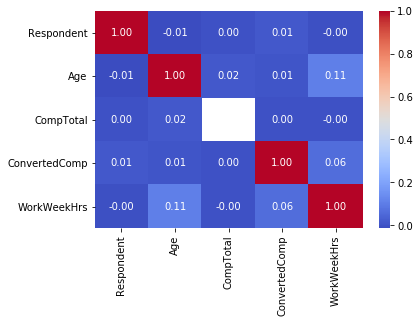

In [27]:
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm'); #Seaborn Heatmap

Let's take a closer look at the salary dimension which is of interest for this exploration. From our df.describe() operation above, we have an intution that there are huge ranges.

In [28]:
#To visualize salary vs. "experience", we have to drop NaN values from relevnt fields first
df = df.dropna(subset=['ConvertedComp','Age','YearsCodePro', 'YearsCode'])


In [29]:
#Using plotly, let's visualize years of professional coding experience against comp (age being a poor proxy here)
fig = px.scatter(df, x='YearsCode', y="ConvertedComp", 
                 size='ConvertedComp', hover_data=['ConvertedComp'],
                 labels={
                     "YearsCode": "Years Coding Experience",
                     "ConvertedComp": "Annual Compensation",
                       },
                title="Annual Compensation by Years of Coding Experience"
                )
fig.show()

Seems all over the map, and clearly we have outliers (2M comp with one year or pretty much any number of years of coding experience?). Let's take a look at a box plot to get a better intuition for the distribution by years of coding experience.

In [30]:
fig = px.box(df, x='YearsCode', y="ConvertedComp",
             labels={
                     "YearsCode": "Years Coding Experience",
                     "ConvertedComp": "Annual Compensation",
                       },
                title="Annual Compensation by Years of Coding Experience"
            )
fig.show()

The box plot is very insightful. It shows us a more clear progression of salary vs. professional coding experience and indicates that we would probably be well advised to clean up outliers before making any assumptions aboout salaries. One likely generator of the salary outliers is the Stack Overflow survey format which apparently does NOT do any kind of inline validation of salary data. This could quite possibly lead a significant number of respondents to specify the wrong pay interval for their responses, e.g. \$60,000 per week vs. per year.  

### Prepare data: Outlier removal and trimming

In [31]:
df['ConvertedComp'].describe()

count    7.204000e+03
mean     2.057389e+05
std      3.675784e+05
min      0.000000e+00
25%      8.300000e+04
50%      1.150000e+05
75%      1.550000e+05
max      2.000000e+06
Name: ConvertedComp, dtype: float64

In [32]:
#Trim data set by quantile
#Utility function in utils.py
df = u.TrimOutliers(df, 'ConvertedComp', 0.10, 0.90)

print(df['ConvertedComp'].describe())

df.head()

count      5736.000000
mean     121032.890167
std       40030.986211
min       62400.000000
25%       90000.000000
50%      115000.000000
75%      145000.000000
max      249000.000000
Name: ConvertedComp, dtype: float64


,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
1,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13
2,14,I am a developer by profession,Yes,27.0,13,Yearly,66000.0,66000.0,United States,United States dollar,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",Angular;Vue.js,Angular;Vue.js,Just as welcome now as I felt last year,40.0,5,1
3,17,I am a developer by profession,Yes,25.0,14,Yearly,79000.0,79000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core;Gatsby;React.js;Vue.js,ASP.NET;Gatsby;jQuery;React.js;Vue.js,Just as welcome now as I felt last year,40.0,7,3
5,19,I am a developer by profession,No,24.0,15,Yearly,83400.0,83400.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;Express;React.js,Angular;Angular.js;ASP.NET Core,Just as welcome now as I felt last year,35.0,9,3
10,42,I am a developer by profession,No,32.0,14,Yearly,130000.0,130000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core;Spring,ASP.NET;Flask;React.js;Spring,Somewhat less welcome now than last year,37.0,16,10


Much more reasonable! Let's try to visualize this one more time with a box plot...

In [33]:
fig = px.box(df, x='YearsCode', y="ConvertedComp",
             labels={
                     "YearsCode": "Years Coding Experience",
                     "ConvertedComp": "Annual Compensation",
                       },
                title="Annual Compensation by Years of Coding Experience"
            )
fig.show()

Nice...this gives an intuitively much more reasonable progression in both salary spread (different experiences over one's career) and a progression that increases with years of experience! Let's see if the same for "Years Professional Coding Experience" produces a materially different result.

In [34]:
fig = px.box(df, x='YearsCodePro', y="ConvertedComp",
             labels={
                     "YearsCodePro": "Years Professional Coding Experience",
                     "ConvertedComp": "Annual Compensation",
                       },
                title="Annual Compensation by Years of Professional Coding Experience"
            )
fig.show()

Very similar, with a bigger divergence towards the tail end and an interesting downward slope on the lower end of the box diagram. Are languages or professional focal areas the root cause for the lower end of the spectrum? Maybe something for future exploration!

### Data focusing

Time to really zoom in on the demographic in question. 
1. Since are interested in data scientists (vs. let's say back-end developers), and people who code for a living, and individuals who are just starting out, let's drop all folks who are working in academic research, who are hobby developers, who did not specify data science / machine learning as at least one of their focus areas and who are above age 30.
2. Distinguish between the educational paths
  a. Maverick: people with some college, a completed bachelor's / associate degree and online education but no master's degree
  b. Traditional: people with a Master's degree (not including Ph.D. or other higher degree)

In [35]:
#1. Data scientist focus and age range
df = df[df['DevType'].str.contains('Data scientist', na=False) 
                & df['MainBranch'].str.contains('I am a developer by profession', na=False)
                & ~df['DevType'].str.contains('Academic researcher', na=False) 
                & (df['Age'] < 31)
       ]
#2. Create two subsets
df_maverick = df[df['EdLevel'].str.contains('Bachelor|Some college/university study|Associate degree')]
df_traditional = df[df['EdLevel'].str.contains('Master')]



In [36]:
fig = px.box(df_maverick, x='Age', y="ConvertedComp",
             labels={
                     "Age": "Age",
                     "ConvertedComp": "Annual Compensation",
                       },
                title="Mavericks: Annual Compensation up to Age 30"
            )
fig.show()

In [37]:
df_maverick.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,66.000000,66.000000,66.000000,66.000000,65.000000
mean,25003.378788,26.030303,112018.363636,112018.363636,42.753846
std,20009.750084,2.756641,37016.462102,37016.462102,7.566437
min,170.000000,21.000000,65000.000000,65000.000000,15.000000
25%,4645.000000,24.000000,85000.000000,85000.000000,40.000000
50%,21844.000000,26.000000,100095.000000,100095.000000,40.000000
75%,45892.500000,28.750000,130000.000000,130000.000000,45.000000
max,62608.000000,30.000000,220000.000000,220000.000000,70.000000


In [38]:
fig = px.box(df_traditional, x='Age', y="ConvertedComp",
             labels={
                     "Age": "Age",
                     "ConvertedComp": "Annual Compensation",
                       },
                title="Traditional (M.A.): Annual Compensation up to Age 30"
            )
fig.show()

In [39]:
df_traditional.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,38.000000,38.000000,38.000000,38.000000,38.000000
mean,31390.026316,27.789474,129884.394737,129884.394737,40.026316
std,20171.547459,1.579564,39018.586733,39018.586733,9.068767
min,587.000000,24.000000,67000.000000,67000.000000,4.000000
25%,17287.000000,26.250000,100500.000000,100500.000000,35.500000
50%,31048.500000,28.000000,129375.000000,129375.000000,40.000000
75%,49856.500000,29.000000,155000.000000,155000.000000,42.750000
max,62882.000000,30.000000,230000.000000,230000.000000,60.000000


Ok, so while our sample sets are getting pretty small now, the numbers from Stack Overflow align directionally with other, reputable public domain data sources. A select list is below. Together with our Stack Overflow data, I'll use them to set the beginning values for the NPV models next. In general, the spread indicated by the Stack Overflow data is bigger than that by salary survey or Job Posting sites like Dice.com or Payscale.com.
 - [Dice](https://insights.dice.com/2020/05/26/data-scientist-salary-starting-average-which-states-pay-most/)
   Bachelor's degree - 111,000 vs. Master's degree - 115,000
 - [Payscale.com](https://payscale.com)
   Bachelor's degree - $103,000 vs. Master's Degree - 107,000



## Data modeling: ROI Calculation - answering the "is it worth it" question

Salary / income is only one part of the equation. What about cost? To figure out the cash outflow, I have researched average costs for a data science Master's Degree as well as expected outlays for online/self-directed education as shown below. 
Additionally, I have assumed typical durations for a Master's Degree to be 2 years and 'alternative' education to be 6 months. 

1. Maverick (some or all of B.A./A.A.) | Incremental data science cost = \$5,000 | Duration = 6 months 
2. Traditional (M.A.)  | Degree cost =  \$60,000 | Duration = 24 months

We are ready to compute the overall ROI for the period of five years following the completion of the online/self-directed or formal education.
Some imporant parameters and (simplifying) assumptions first
 - Student Loan Interest rate for graduate borrowers: [4.30%](https://studentaid.gov/understand-aid/types/loans/interest-rates)
 - Average time to repay student loan: [20 years](https://www.cnbc.com/2019/05/23/cengage-how-long-it-takes-college-grads-to-pay-off-student-debt.html#:~:text=The%20Department%20of%20Education%20reports,debt%20borrowers%20is%2021.1%20years.)
 - Raise of [3% every year](https://www.investopedia.com/articles/personal-finance/090415/salary-secrets-what-considered-big-raise.asp)
 - Long running average return S&P Index of [8% per year](https://www.investopedia.com/ask/answers/042415/what-average-annual-return-sp-500.asp)

In [40]:
#Initiate variables - Mavericks
principal = 5000 #Cost to attend online/bootcamp classes
interest_rate = 0.043 #Loan interest
payback_years = 4 #Amount of time to pay back loan
explore_years = 20 #Time period we want to explore from start of education 
annual_payments = 12 #Loan payments/year
sp_return = 0.08 #Expected S&P return for savings going to S&P Index fund
savings_rate = 0.05 #Amount of income saved / month
duration = 6 #duration of education, in months
annual_income = 100000 #starting salary - blended figure from Stack Overflow data and public domain sources
annual_raise = 0.03 #Expected average annual raise
start_date = date.today() #observation period start

Ready to populate a dataframe with results for Mavericks. Encapsulating this into function that uses Yield to incrementally fill dataframe for later visualization and lives in utils.py.

In [41]:
#Time to fill the dataframe with the function above that will row-wise OrdereDict
df_maverick = pd.DataFrame(u.calc_ROI(principal, interest_rate, payback_years, explore_years, annual_payments, 
                                      sp_return, savings_rate, duration, annual_income, annual_raise, start_date))

fig = go.Figure()
fig.add_trace(go.Bar(x=df_maverick['Month'], y=df_maverick['Income'], name='Income'))
fig.add_trace(go.Bar(x=df_maverick['Month'], y=df_maverick['SP_balance'], name='S&P Balance'))
fig.add_trace(go.Bar(x=df_maverick['Month'], y=df_maverick['Loan_Balance'],name='Loan Balance'))
fig.add_trace(go.Scatter(x=df_maverick['Month'],y=df_maverick['Total'], name='Total'))
fig.update_layout(barmode='relative', title_text='Overall Return - Maverick')
fig.show()

In [42]:
df_maverick.tail()

,Month,Period,Income,SP_balance,Loan_Balance,Total
235,2040-04-10,236,14612.55,280623.11,0.0,295235.66
236,2040-05-10,237,14612.55,283229.43,0.0,297841.98
237,2040-06-10,238,14612.55,285853.12,0.0,300465.67
238,2040-07-10,239,14612.55,288494.31,0.0,303106.86
239,2040-08-10,240,14612.55,291153.10,0.0,305765.65


Same for Traditional approach

In [43]:
#Initiate variables - Traditional
principal = 60000 #Cost to attend high-quality Master's degree program
interest_rate = 0.043 #Loan interest
payback_years = 20 #Amount of time to pay back loan
explore_years = 20 #Time period we want to explore from start of education 
annual_payments = 12 #Loan payments/year
sp_return = 0.08 #Expected S&P return for savings going to S&P Index fund
savings_rate = 0.05 #Amount of income saved / month
duration = 24 #duration of education, in months
annual_income = 130000 #starting salary
annual_raise = 0.03 #Expected average annual raise

In [44]:
#def calc_ROI_New(principal, interest_rate, payback_years, explore_years, annual_payments, sp_return, savings_rate, duration, 
#             annual_income, annual_raise, start_date=date.today()):
df_traditional = pd.DataFrame(u.calc_ROI(principal, interest_rate, payback_years, explore_years, annual_payments, 
                                      sp_return, savings_rate, duration, annual_income, annual_raise, start_date))
fig = go.Figure()
fig.add_trace(go.Bar(x=df_traditional['Month'], y=df_traditional['Income'], name='Income'))
fig.add_trace(go.Bar(x=df_traditional['Month'], y=df_traditional['SP_balance'], name='S&P Balance'))
fig.add_trace(go.Bar(x=df_traditional['Month'], y=df_traditional['Loan_Balance'],name='Loan Balance'))
fig.add_trace(go.Scatter(x=df_traditional['Month'],y=df_traditional['Total'], name='Total'))

fig.update_layout(barmode='relative', title_text='Overall Return - Traditional')
fig.show()



In [45]:
df_traditional.tail()

,Month,Period,Income,SP_balance,Loan_Balance,Total
235,2040-04-10,236,17905.85,308046.77,-9925.01,316027.61
236,2040-05-10,237,17905.85,311001.68,-9587.43,319320.10
237,2040-06-10,238,17905.85,313976.29,-9248.64,322633.50
238,2040-07-10,239,17905.85,316970.73,-8908.64,325967.94
239,2040-08-10,240,17905.85,319985.13,-8567.42,329323.56


In [46]:
#Plot together
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_maverick['Month'], y=df_maverick['Total'],
                    mode='lines',
                    name='Maverick Total Net Worth'))
fig.add_trace(go.Scatter(x=df_traditional['Month'], y=df_traditional['Total'],
                    mode='lines',
                    name='Traditional Total Net Worth'))
fig.add_trace(go.Scatter(x=df_maverick['Month'], y=df_maverick['Income']*12,
                    mode='lines',
                    name='Maverick Annual Income'))
fig.add_trace(go.Scatter(x=df_traditional['Month'], y=df_traditional['Income']*12,
                    mode='lines',
                    name='Traditional Annual Income'))
fig.update_layout(barmode='relative', title_text='Overall Net Worth and Income - Maverick vs. Traditional')
fig.show()

## Evaluating the result 

In this grossly simplified exploration, we observe the following
- Traditionalists have a minor net worth advantage at the end of the 20 year observation period that will grow over time
- Traditionalists have a pronounced salary advantage that will continue to grow over time
- Starting to earn sooner (even at a lower level) pays off if you save some of your income in a compounding asset
    - The power of early compounding returns for Mavericks is significant and the large student loan debt for Traditionalists means that their net worth doesn't catch up to Mavericks until 2037

Naturally, there are many potential different outcomes, e.g. if annual salary increases on average are e.g. 6% for traditionalists vs. 5% for Mavericks, or if the savings rate were slightly different between cohorts, etc. etc.

So, to return to the question raised at the beginning of this notebook, the answer is "definitely maybe, but it depends!"
